<a href="https://colab.research.google.com/github/Alassane-DIAllo/AI-in-Trading-Centrale/blob/master/BERT_algorithm_Cosmic_Automation_version3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### *We will be presenting the implementation of the BERT algorithm for the Name Entity Recogntion task*. 

### **Summary of the Task**
####To quickly summarize our task, we are trying to build a NLP model to detect the name entities associated to an input data. For now on, we will be considering two entities : "Data group" and "Data mouvement". 

### **For doing so, we will consider the following steps:** 
- Importation of the Data : the data we will be working on has a specific format in accordance with the NER task . 

- Data engineering: In this step, we will be working on our dataset. More specifically we will clean it,  we will seperate the inputs data from the targets(which represent the name entity tags) .The data will be split into training dataset and validation dataset, so that the performance of the model can be evaluated. 
Also, We will make use of the pytorch dataloader to load the batches of training dataset as well and the validation dataset. 

- Then, we will build our BERT algorithm to perform the name entity task. The model can be found on the **transformers** library .  

- After defining the model architecture , we will train it using the train dataloader , then validate the model with the test dataloader.

- To evaluate the performance of our model, we make use of a F1-score metric. This compares the precision of the model to the recall and is very used in real world classification problem . It can be written as : 

$$ F1-score = \frac{2*precision* recall}{precision+ recall}$$

- To finish , we will deploy the model to production using flask and AWS . 


In [ ]:
## mount the drive in the colab notebook 
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###**Package installation**

In [ ]:
!pip install ktrain

### **1-Data Description**

For the moment the data we will be using for estimanting the CFP is unknown. For illustrative purposes, we will be using a similar data format, which we will use to to train the Bert model. The implementation we will be performing is data independent, which means that the same implementation can be used for a different dataset. The data can be found under the name "ner.csv" on the data_estimancy folder . 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:

df1 = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/Data_Estimancy/ENEDIS_taggage.xlsx") 
df2 = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/Data_Estimancy/IDES.xlsx")
df3 = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/Data_Estimancy/casestudy.xlsx")

df = pd.DataFrame()
df = df.append([df1, df2, df3])

We will only consider three caracteristics of the data : "pos", "word", "sentence_idx" representing the "part of speech " of each "word" belonging to the sentence of id : "sentence_idx". This choice of feature set is for the purpose of simplicity . The feature set can eventually be extended to improve the performance of the model . 

In [ ]:
df = df[[ "word", "sentence_idx", "tag"]].dropna()

In [ ]:
df.head()

,word,sentence_idx,tag
0,To,1.0,O
1,access,1.0,O
2,the,1.0,O
3,application,1.0,O
4,from,1.0,O


In [ ]:
print("Total number of sentences {0}".format(df["sentence_idx"].nunique()))

print("Total number of words {}".format(df["word"].shape[0]))

Total number of sentences 189
Total number of words 6073


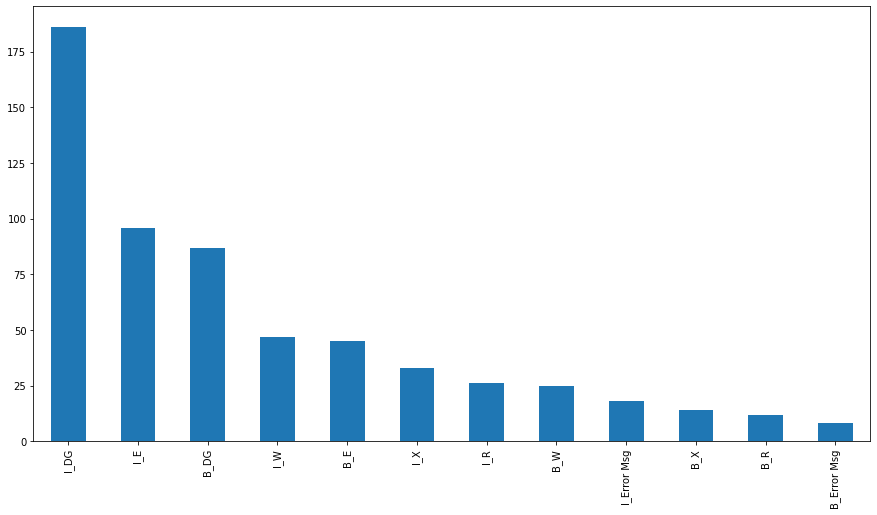

In [ ]:
df[df["tag"]!='O']["tag"].value_counts().plot(kind="bar", figsize=(15, 8))
plt.show()

The next step would be to perform the Data engineering. This envolves putting words wich belonging same sentence, separating the target data from the input data, vectorizing the textual data to numerical data, ect... 

In [ ]:
word_count = df.groupby("sentence_idx")["word"].agg(["count"])

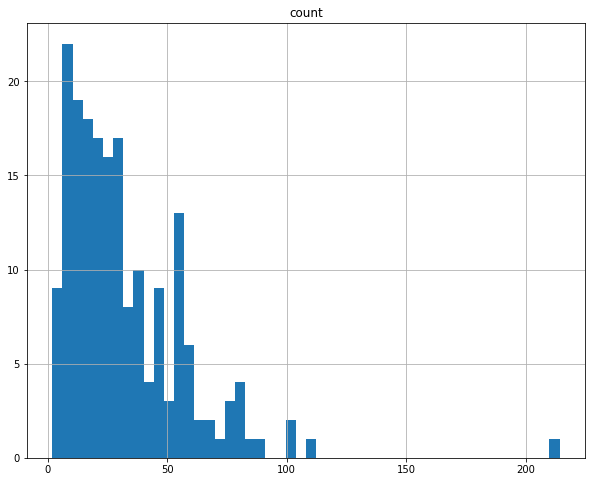

In [ ]:
word_count = word_count.rename({'count': 'Word Count'})
word_count.hist(bins=50, figsize=(10,8))
plt.show()

In [ ]:
print("longest sentence contains {} words ".format(word_count.max()))

longest sentence contains count    214
dtype: int64 words 


### **Use of NLTK library to find the part of speech**




In [ ]:
import nltk 
from nltk.tokenize import word_tokenize #word tokenizer transform sentences to words  
from nltk.probability import FreqDist

In [ ]:
nltk.download('punkt')

In [ ]:
Sentences  = [ ' '.join(str(item) for item in s ) for s in df.groupby("sentence_idx").apply(lambda x : x["word"].tolist())]
list_tag  = [ ' '.join(str(item) for item in s ) for s in df.groupby("sentence_idx").apply(lambda x : x["tag"].tolist())]

In [ ]:
tokenized_word = [word_tokenize(text) for text in Sentences]
fdist = FreqDist(tokenized_word[0])
fdist.most_common(10)

[('customer', 19),
 ('the', 18),
 ('System', 11),
 ('for', 7),
 (',', 5),
 ('a', 5),
 ('and', 5),
 ('name', 5),
 ('details', 5),
 ('case', 4)]

In [ ]:
 word_tokenize_total = []
 for sent in tokenized_word:
   word_tokenize_total.extend(sent)

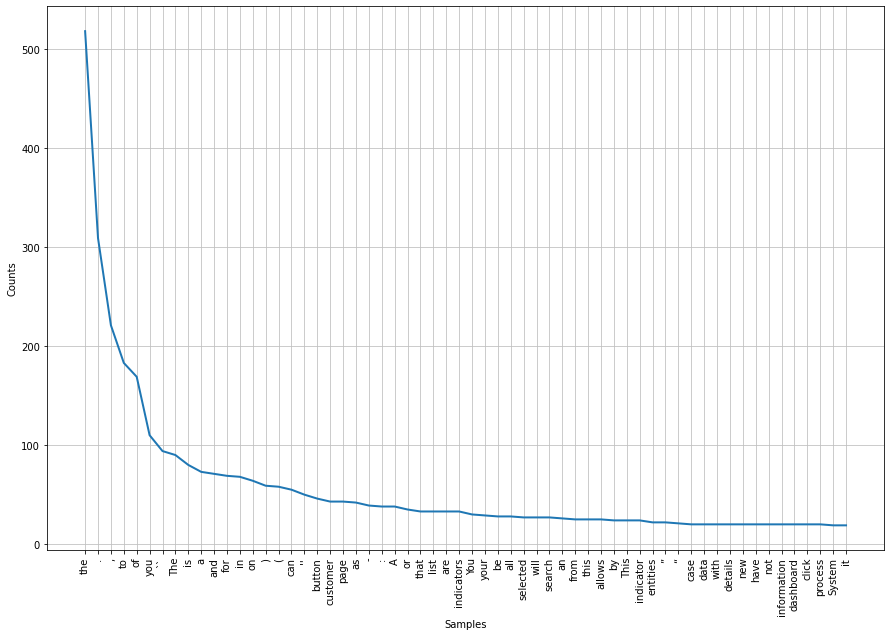

In [ ]:
fdist = FreqDist(word_tokenize_total)
plt.figure(figsize=(15,10))
fdist.plot(60, cumulative=False)
plt.show()

In [ ]:
from nltk.corpus import stopwords
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
stop_words = set(stopwords.words("english"))

In [ ]:
text_without_stop_word = [ word for word in word_tokenize_total if word not in stop_words]

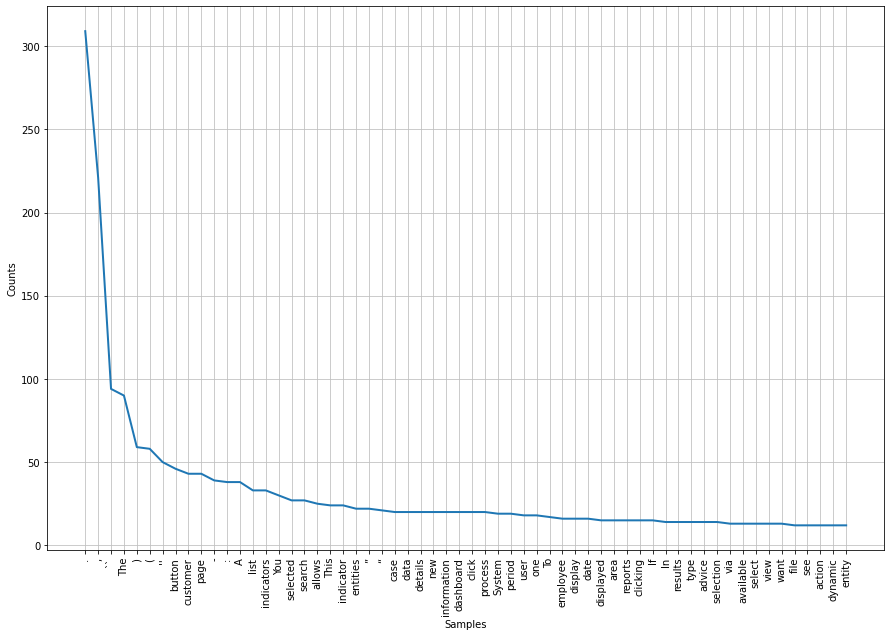

In [ ]:
fdist = FreqDist(text_without_stop_word)
plt.figure(figsize=(15,10))
fdist.plot(60, cumulative=False)
plt.show()

### Part of speech tagging 

In [ ]:
 nltk.download('averaged_perceptron_tagger')

In [ ]:
pos_sentence = [nltk.pos_tag(text) for text in tokenized_word]

In [ ]:
new_dataframe = pd.DataFrame()
new_dataframe["pos"] = pos_sentence
new_dataframe["sentence"] = [sent.split(' ') for sent in Sentences]
new_dataframe["tag"] = [tag.split(' ') for tag in list_tag ]

In [ ]:
new_dataframe

,pos,sentence,tag
0,"[(To, TO), (access, NN), (the, DT), (applicati...","[To, access, the, application, from, your, Int...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
1,"[(enedis, NN), (., .), (For, IN), (example, NN...","[enedis, ., For, example, ,, we, speak, of, ""e...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
2,"[(fr, NN), (., .), (This, DT), (case, NN), (wi...","[fr, ., This, case, will, contain, the, flow, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
3,"[(It, PRP), (is, VBZ), (recommended, VBN), (to...","[It, is, recommended, to, use, Firefox, ., ., ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
4,"[(you, PRP), (can, MD), (access, NN), (ePURE, ...","[you, can, access, ePURE, only, through, the, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
...,...,...,...
184,"[(You, PRP), (can, MD), (choose, VB), (the, DT...","[You, can, choose, the, desired, period, by, c...","[O, O, B_E, B_DG, B_DG, I_DG, O, O, O, O, O, O..."
185,"[(A, DT), (calendar, NN), (allows, VBZ), (you,...","[A, calendar, allows, you, to, choose, the, ye...","[O, O, O, O, O, O, B_DG, I_DG, I_DG, I_DG, I_D..."
186,"[(A, DT), (button, NN), (“, NNP), (Reinitializ...","[A, button, “Reinitialize, filters”, allows, y...","[O, O, O, O, O, O, B_W, I_W, B_DG, I_DG, O, O,..."
187,"[(The, DT), (selection, NN), (of, IN), (the, D...","[The, selection, of, the, entity, and, the, pe...","[O, O, O, O, O, O, O, O, O, O, O]"


In [ ]:
for elm in all_words:
  if elm =='To':
    print(elm) 

To


In [ ]:
from collections import defaultdict

In [ ]:
all_words = list(set(df["word"]))
all_tag = list(set(df["tag"]))


word2index = defaultdict(lambda : 0)
tag2index = defaultdict(lambda : 0)
for idx, word  in enumerate(all_words) :
  word2index[word] = idx+2 

for idx, tag in enumerate(all_words):
    tag2index[tag] = idx+1

word2index["--PADDING--"] = 1
tag2index["--PADDING--"] = 1

In [ ]:
X_data = [ [word2index[word] for word in sent] for sent in new_dataframe["sentence"]]
Y_data = [[tag2index[tag] for tag in tags] for tags in new_dataframe["tag"]]

###### **Since the LSTM model is expecting a fixed sized input, we will modify both X_data and Y_data to account for this** . We will make use of the PADDING .




In [ ]:
MAX_SENTENCE= max(len(sentence) for sentence in X_data )

In [ ]:
X = [sentence + [word2index["--PADDING--"]]*(MAX_SENTENCE-len(sentence)) for sentence in X_data]
Y = [sentence + [tag2index["--PADDING--"]]*(MAX_SENTENCE-len(sentence)) for sentence in Y_data]

### **2- feature engineering**
To perform the feature engineering, we use the Dataset class .  

In [ ]:
class Dataset:
  def __init__(self, dataset):
      self.dataset = dataset 
      self.n_sentence = 1
      self.labels = self.dataset["tag"]
      funct = lambda s : [ [w, p, t] for w, p, t in zip(s["word"].values.tolist(), s["pos"].values.tolist(), s["tag"].values.tolist())]
      self.group = self.dataset.groupby("sentence_idx").apply(funct)
      self.sentences = [s for s in self.group]
      
  def get_next_sentence(self, index):
      next_sent = self.group_data[index]
      self.n_sentence +=1 
      return next_sent 


In [ ]:
data = Dataset(df)  

In [ ]:
list_tag = list(set(data.labels))
sentences = [' '.join([s[0] for s in sent]) for sent in data.sentences]
tag2idx = {t : i for i, t in enumerate(list_tag)}
labels = [ [tag2idx[s[2]] for s in sent] for sent in data.sentences]

### **Preparing the Dataset and the Dataloader** 

Dataset and Dataloader are constructs of pytorch library . Dataset is used to perform some processing on the data before sending it to the model . Dataloader allows the data to be sent in batches in the model for training performances.  
We will define the Dataset class which takes `tokenizer`, `sentences`, `labels` as inputs and outputs tokenized sentences and tags, that are used to train the model. 


In [ ]:
!pip install transformers 

In [ ]:
import numpy as np 
import pandas as pd  
import transformers 
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler 
from transformers import BertForTokenClassification, BertTokenizer, BertConfig, BertModel 

In [ ]:
!pip install torch
!pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl

#### We will make use of torch_xla, which allows computation in the TPU . 

In [ ]:
import torch
import torch_xla
import torch_xla.core.xla_model as xm
from sklearn.model_selection import train_test_split 

 #### **Dataset Class** 
- the Dataset class takes as input `tokenizer`, `sentences`, `labels`  and tokenizes the sentences .
- We use BertTokenizer to tokenize the sentences to [ids] and [mask] for encoding. 
- the tokenizer uses encode_plus to tokenize the data . 

*Dataloader*
The dataloader is used to divide the dataset into batches, that are loaded into a variable. To do so, we use 2 variables: `bach_size` and `max_size`. 


In [ ]:
class CustomDataset(Dataset):
  def __init__(self, tokenizer, sentences, labels, max_len=100):
    self.tokenizer = tokenizer 
    self.sentences = sentences
    self.labels = labels
    self.max_len = max_len 
    self.len = len(self.sentences)

  def __getitem__(self, index):

    sentence = str(self.sentences[index])
    tokenized = self.tokenizer.encode_plus(
        sentence,
        add_special_tokens =True,
        truncation = True, 
        max_length = self.max_len, 
        padding = 'max_length',
        return_token_type_ids = True 
    )
    
    ids = tokenized["input_ids"]
    mask = tokenized["attention_mask"]
    labels = self.labels[index]
    labels.extend([0]*max_len)
    labels = labels[:max_len]

    return {'ids':torch.tensor(ids, dtype = torch.long), 'mask':torch.tensor(mask, dtype = torch.long),
            'tags':torch.tensor(labels, dtype = torch.long)}
  
  def __len__ (self):
    return self.len 

In [ ]:
### Constant variables

max_len = 100
train_batch_size = test_batch_size = 20 
data_size = len(sentences)
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=True)

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

### **Training** set and **Testing** set

In [ ]:
train_sentences, test_sentences, train_labels, test_labels = train_test_split(sentences, labels, test_size=0.2, random_state=2021)
train_data = CustomDataset(tokenizer, train_sentences, train_labels, max_len)
test_data  = CustomDataset(tokenizer, test_sentences, test_labels, max_len)
train_sampler = RandomSampler(train_data)
test_sampler = RandomSampler(test_data)
bs=20

####**Dataloader**

In [ ]:
train_dataloader = DataLoader(train_data, batch_size=bs, sampler =train_sampler)
test_dataloader  = DataLoader(test_data, batch_size=bs, sampler= test_sampler)



```
# This is formatted as code
```

### **4-Model building**

In [ ]:
import torch.nn as nn

In [ ]:
class BertClass(nn.Module): 
  def __init__(self, list_tag):
      # first layer of the bert model 
      super(BertClass, self).__init__()
      self.l1 = BertForTokenClassification.from_pretrained('bert-base-cased', num_labels = len(tag2idx)) 
      # self.Dropout = nn.Dropout(0.2)
      # self.fc1 = nn.Linear(784, 200)
      # self.fc2 = nn.Linear(200, 100)
      # self.fc3 = nn.Linear(100, len(list_tag))
  
  def forward(self, ids, mask, labels): 
      x = self.l1(ids, mask, labels=labels)
      # x=  self.Dropout(x)
      # x = self.fc1(x)
      # x=  self.fc2(x)
      # x = self.fc3(x) 
      return x 
      


In [ ]:
### to perform computations of the model on the TPU 
dev = xm.xla_device()

In [ ]:
model = BertClass(list_tag)
model.to(dev)

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

BertClass(
  (l1): BertForTokenClassification(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(28996, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=True)
       

In [ ]:
Learning_rate = 1e-05
EPOCHS= 10 
optimizer = torch.optim.Adam(params = model.parameters(), lr=Learning_rate) 

###**Training/Evaluation of the model

```
# This is formatted as code
```

** 

In [ ]:
from seqeval.metrics import f1_score

In [ ]:
!pip install seqeval

In [ ]:
def val():

    model.eval()
    predictions, true_labels = [], []
    eval_accuracy, eval_loss, n_batch = 0.0 , 0.0, 0.0

    def Accuracy(predictions, labels):
        flat_predictions = np.argmax(predictions, axis=2).flatten()
        flat_labels =labels.flatten()
        return (flat_labels==flat_predictions).sum()/len(flat_labels)

    with torch.no_grad():
      data = next(iter(test_dataloader))
      ids   =  data["ids"].to(dev, dtype = torch.long)
      mask  =  data["mask"].to(dev, dtype = torch.long)
      labels = data["tags"].to(dev, dtype = torch.long)

      output = model(ids, mask, labels=labels)
      loss, logits = output[:2]

      logits = logits.detach().to('cpu').numpy()
      labels = labels.to('cpu').numpy()

      predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
      true_labels.extend([list(l) for l in labels])

      eval_accuracy= Accuracy(logits, labels)
      eval_loss= loss.mean().item()

      predic_tags = [[list_tag[p_i] for p_i in p ] for p in predictions]
      true_tags = [[list_tag[l_i] for l_i in l ] for l in true_labels]
      print(f"validation  loss = %.3f,   validation_accuracy= %.3f" %(eval_loss, eval_accuracy))

In [ ]:
def train_val(epochs):

  max_grad_norm = 1
  for ep in range(epochs):
      loss_sum, num_train = 0.0, 0.0 

      for i, data in enumerate(train_dataloader):
        model.train()

        ids = data["ids"].to(dev, dtype=torch.long)
        mask = data["mask"].to(dev, dtype = torch.long)
        labels = data["tags"].to(dev, dtype= torch.long)

        loss = model(ids, mask, labels=labels)[0]  
        loss.backward()

        loss_sum+=loss.item()
        num_train += ids.size(0)
        #gradient clipping 
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=max_grad_norm)
        # update parameters 
        xm.optimizer_step(optimizer)
        xm.mark_step()
        #initialize gradient 
        model.zero_grad()

        if i%2000==0:
          print(f"epoch = {ep+1} .....")
          print(f"train_loss={loss_sum/num_train}")
          val()
         

In [ ]:
train_val(EPOCHS)

epoch = 1 .....
train_loss=0.14714175462722778
validation  loss = 2.793,   validation_accuracy= 0.030
validation Accuracy =0.03
epoch = 2 .....
train_loss=0.014681755006313324
validation  loss = 0.257,   validation_accuracy= 0.908
validation Accuracy =0.9085
epoch = 3 .....
train_loss=0.006789017468690872
validation  loss = 0.232,   validation_accuracy= 0.902
validation Accuracy =0.902
epoch = 4 .....
train_loss=0.012005510926246642
validation  loss = 0.131,   validation_accuracy= 0.924
validation Accuracy =0.9245
epoch = 5 .....
train_loss=0.004881956428289413
validation  loss = 0.160,   validation_accuracy= 0.904
validation Accuracy =0.9045
epoch = 6 .....
train_loss=0.011109494417905808
validation  loss = 0.130,   validation_accuracy= 0.942
validation Accuracy =0.942
epoch = 7 .....
train_loss=0.005349944159388542
validation  loss = 0.246,   validation_accuracy= 0.901
validation Accuracy =0.9015
epoch = 8 .....
train_loss=0.006590496003627777
validation  loss = 0.143,   validation_a

In [ ]:
## evaluation of the model on the validation set
val()

validation  loss = 0.142,   validation_accuracy= 0.934
validation Accuracy =0.9345


In [ ]:
idx2tag = {i: w for w, i in tag2idx.items()}

def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("PAD", "O"))
        out.append(out_i)
    return out
    
pred_labels = pred2label(test_pred)
test_labels = pred2label(y_te)

###**Prediction on a random sentence**

In [ ]:
# test with a random data 

sentence= [" I have recently watched a new movie on primevideo"]
data = CustomDataset(tokenizer, sentence, labels)

In [ ]:
random_sampler = RandomSampler(data)
dataloader = DataLoader(data, sampler=random_sampler)

In [ ]:
model.eval()
predictions = []
for data in dataloader:
  input_ids = data["ids"].to(dev, dtype=torch.long)
  masks = data["mask"].to(dev, dtype=torch.long)
  labels = data["tags"].to(dev, dtype=torch.long)
  with torch.no_grad():
    logits = model(input_ids, masks, labels)[1]
    logits = logits.detach().to('cpu').numpy()
    predictions.extend([list(p) for p in np.argmax(logits, axis=2)])

pred = [[list_tag[p_ii] for p_ii in p] for p in predictions]
print(pred)

[['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-org', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'I-org', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'I-org', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-org', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-org', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']]


##**Hyperparameters tuning** 

##**Ktrain library to improve Bert Model**

### Ktrain is a library that makes easier both the implementation and the deployment of Deep learning based models . It is inspired by the fast ai library in that,  with only a few lines of codes , it can estimate an optimal learning rate for the Deep learning model. Besides, it can also perform the preprocessing of the input data by using this library. 

####For further detail on the ktrain library, check out this github [https://github.com/amaiya/ktrain]()

In [ ]:
import ktrain
from ktrain import text, get_learner 

In [ ]:
class Ktrain:

  def __init__(self, data):
    self.data = data
    self.preproc = None 
    self.train = None
    self.val = None
    self.model = None 
    self.learner = None 

  def processing(self):
      """
      Load entities from pandas DataFrame
      Args:
        train_df(pd.DataFrame): training data
        val_df(pdf.DataFrame): validation data
        word_column(str): name of column containing the text
        tag_column(str): name of column containing lael
        sentence_column(str): name of column containing Sentence IDs
        use_char(bool):    If True, data will be preprocessed to use character embeddings  in addition to word embeddings
        verbose (boolean): verbosity

      """
      self.train, self.val, self.preproc = text.entities_from_df(train_df=self.data.iloc[:100000], 
                                                                   word_column="word", sentence_column='sentence_idx',
                                                                   tag_column='tag',
                                                                   val_pct = 0.3, 
                                                                   use_char=False, verbose=1)

  def Model(self, ModelName):
    # the name of the model "ModelName" could be : Bi-LSTM-CRF, BERT, DistilBERT 
      self.model = text.sequence_tagger(ModelName, self.preproc)
      self.learner =get_learner(self.model, train_data=self.train, val_data =self.val,
                                   batch_size = 50,eval_batch_size = 50)
      return self.model 

###**Bert model** 

In [ ]:
if __name__=='__main__': 
  Ktrain = Ktrain(data=df)
  print("******************** preprocessing step ******************************")
  print("                                                                      ")

  print("                                                                      ")

  Ktrain.processing()
  print("******************* Model Building ***********************************")

  model = Ktrain.Model('bilstm-bert')

  print("                                                                      ")
  print("                                                                      ")
  print("*********************** Model training and Evaluation ******************")
  print("                                                                      ")
  print("                                                                      ")
  learner = Ktrain.learner
  learner.fit(1e-03, 10)

  print("                                                                      ")

  print("                                                                      ")
  print("******************** Model Summary *************************************")
  learner.validate()

  print("                                                                      ")
  print("                                                                      ")
  print("(****************** Model view top losses *****************************")

  print("                                                                      ")
  print("                                                                      ")
  learner.view_top_losses(n=1)
  print("                                                                      ")
  print("                                                                      ")
  print("****************** Definition of a Predictor ************************")
  predictor = ktrain.get_predictor(learner.model, Ktrain.preproc)

  print("                                                                      ")
  print("                                                                      ")
  print("****************** Save the Predictor ************************")
  predictor.save('/content/bert')

  





******************** preprocessing step ******************************
                                                                      
                                                                      
Number of sentences:  4544
Number of words in the dataset:  10922
Tags: ['B-org', 'I-gpe', 'B-per', 'B-art', 'I-tim', 'B-tim', 'I-nat', 'I-geo', 'B-gpe', 'B-geo', 'I-art', 'B-eve', 'I-per', 'B-nat', 'I-eve', 'I-org', 'O']
Number of Labels:  17
Longest sentence: 70 words
******************* Model Building ***********************************
Embedding schemes employed (combined with concatenation):
	word embeddings initialized randomly
	BERT embeddings with bert-base-multilingual-cased



Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/996k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.08G [00:00<?, ?B/s]

                                                                      
                                                                      
*********************** Model training and Evaluation ******************
                                                                      
                                                                      
preparing training data ...done.
preparing validation data ...done.
Epoch 1/10
64/64 [==============================] - 950s 15s/step - loss: 0.3640 - val_loss: 0.1837
Epoch 2/10
64/64 [==============================] - 923s 14s/step - loss: 0.1554 - val_loss: 0.1158
Epoch 3/10
64/64 [==============================] - 925s 15s/step - loss: 0.1105 - val_loss: 0.1019
Epoch 4/10
64/64 [==============================] - 925s 14s/step - loss: 0.0936 - val_loss: 0.0992
Epoch 5/10
64/64 [==============================] - 923s 14s/step - loss: 0.0836 - val_loss: 0.0926
Epoch 6/10
64/64 [==============================] - 920s 14s/step - loss: 0

##**BILSTM**

In [ ]:




if __name__=='__main__': 
  Ktrain = Ktrain(data=df)
  print("******************** preprocessing step ******************************")
  print("                                                                      ")

  print("                                                                      ")

  Ktrain.processing()
  print("******************* Model Building ***********************************")

  model = Ktrain.Model('bilstm-crf')

  print("                                                                      ")
  print("                                                                      ")
  print("*********************** Model training and Evaluation ******************")
  print("                                                                      ")
  print("                                                                      ")
  learner = Ktrain.learner
  learner.fit(1e-03, 50)

  print("                                                                      ")

  print("                                                                      ")
  print("******************** Model Summary *************************************")
  learner.validate()

  print("                                                                      ")
  print("                                                                      ")
  print("(****************** Model view top losses *****************************")

  print("                                                                      ")
  print("                                                                      ")
  learner.view_top_losses(n=1)
  print("                                                                      ")
  print("                                                                      ")
  print("****************** Definition of a Predictor ************************")
  predictor = ktrain.get_predictor(learner.model, Ktrain.preproc)

  print("                                                                      ")
  print("                                                                      ")
  print("****************** Save the Predictor ************************")
  predictor.save('/content/bilstm')

******************** preprocessing step ******************************
                                                                      
                                                                      
Number of sentences:  4544
Number of words in the dataset:  10922
Tags: ['B-org', 'I-gpe', 'B-per', 'B-art', 'I-tim', 'B-tim', 'I-nat', 'I-geo', 'B-gpe', 'B-geo', 'I-art', 'B-eve', 'I-per', 'B-nat', 'I-eve', 'I-org', 'O']
Number of Labels:  17
Longest sentence: 70 words
******************* Model Building ***********************************

IMPORTANT NOTE: ktrain uses the CRF module from keras_contrib, which is not yet
fully compatible with TensorFlow 2. You can still use the BiLSTM-CRF model
in ktrain for sequence tagging with TensorFlow 2, but you must add the
following to the top of your script or notebook BEFORE you import ktrain:

import os
os.environ['DISABLE_V2_BEHAVIOR'] = '1'

For this run, a vanilla BiLSTM model (with no CRF layer) will be used.

embedding schemes em

/usr/local/lib/python3.7/dist-packages/ktrain/text/ner/models.py:108: UserWarning: Falling back to BiLSTM (no CRF) because DISABLE_V2_BEHAVIOR=False
  warnings.warn('Falling back to BiLSTM (no CRF) because DISABLE_V2_BEHAVIOR=False')


                                                                      
                                                                      
*********************** Model training and Evaluation ******************
                                                                      
                                                                      
preparing training data ...done.
preparing validation data ...done.
Epoch 1/20
64/64 [==============================] - 20s 198ms/step - loss: 0.6109 - val_loss: 0.3791
Epoch 2/20
64/64 [==============================] - 10s 159ms/step - loss: 0.3232 - val_loss: 0.2619
Epoch 3/20
64/64 [==============================] - 10s 159ms/step - loss: 0.2320 - val_loss: 0.2212
Epoch 4/20
64/64 [==============================] - 10s 157ms/step - loss: 0.1964 - val_loss: 0.1966
Epoch 5/20
64/64 [==============================] - 10s 155ms/step - loss: 0.1650 - val_loss: 0.1745
Epoch 6/20
64/64 [==============================] - 10s 158ms/step - l

### **Model Comparison**

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
Bert_val_accuracy=[0.908, 0.902, 0.924, 0.904, 0.942, 0.901, 0.905, 0.921, 0.934]
Bert_kaggle = [0.9267, 0.939435, 0.94627]

Model = {"my_Bert":[0.908, 0.902, 0.924, 0.904, 0.942, 0.901, 0.905, 0.921, 0.934], "Bert_kaggle": [0.9267, 0.939435, 0.94627],\
         "LSTM":[0.9681, 0.9681,0.9682,0.9683,0.9684,0.9685,0.9686,0.9687,0.9688, 0.9689],"Simple-RNN":[0.975, 0.980, 0.987, 0.988, 0.989],\
         "Bi-LSTm-CRF": [0.9276, 0.9789, 0.9872, 0.9906, 0.9919]}

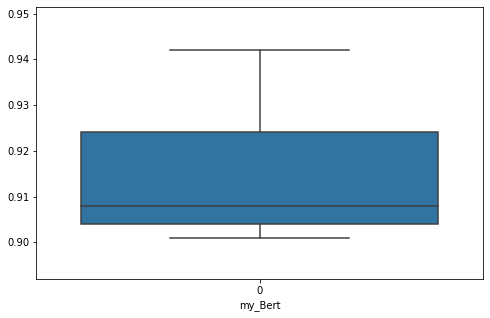

In [ ]:
plt.figure(figsize=(8,5))
sns.boxplot(data=Model["my_Bert"])
plt.ylim(ymin=0.99*min(Bert_val_accuracy) , ymax = 1.01*max(Bert_val_accuracy))
plt.xlabel("my_Bert")
plt.show()

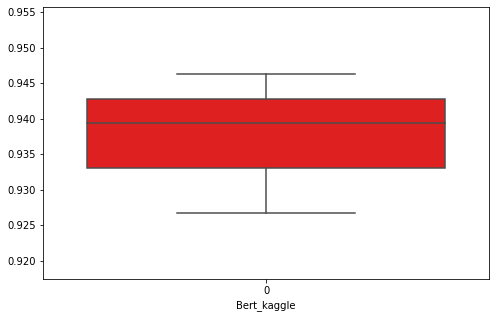

In [ ]:
plt.figure(figsize=(8,5))
sns.boxplot(data=Model["Bert_kaggle"], color="red")
plt.ylim(ymin=0.99*min(Model["Bert_kaggle"]) , ymax = 1.01*max(Model["Bert_kaggle"]))
plt.xlabel("Bert_kaggle")
plt.show()

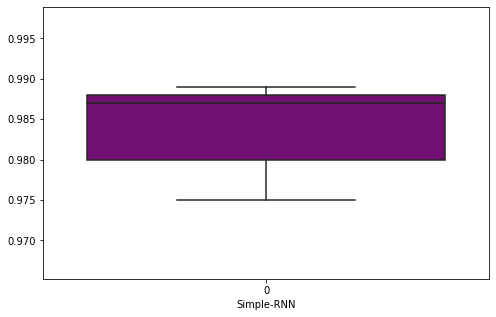

In [ ]:
plt.figure(figsize=(8,5))
sns.boxplot(data=Model["Simple-RNN"], color="purple")
plt.ylim(ymin=0.99*min(Model["Simple-RNN"]) , ymax = 1.01*max(Model["Simple-RNN"]))
plt.xlabel("Simple-RNN")
plt.show()

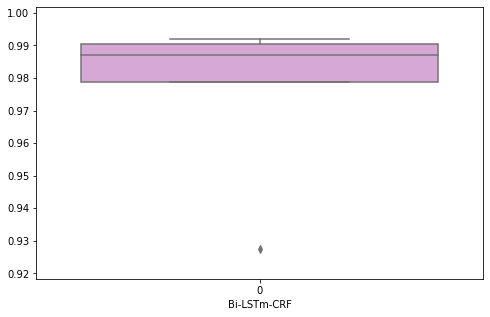

In [ ]:
plt.figure(figsize=(8,5))
sns.boxplot(data=Model["Bi-LSTm-CRF"], color="#DDA0DD")
plt.ylim(ymin=0.99*min(Model["Bi-LSTm-CRF"]) , ymax = 1.01*max(Model["Bi-LSTm-CRF"]))
plt.xlabel("Bi-LSTm-CRF")
plt.show()

### **F-Score** comparison